In [ ]:
# COHORT_ROKU_NEW_102022 

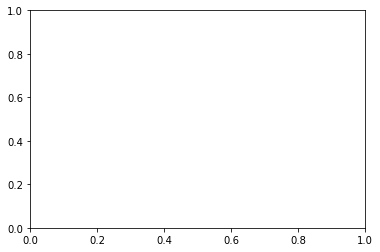

In [1]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import configparser
from sqlalchemy import create_engine
import seaborn as sns

pd.options.display.float_format = "{:,.2f}".format
plt.ticklabel_format(style='plain');

In [2]:
config = configparser.ConfigParser()
config.read(r'C:\Users\mairag0502\config.ini')
user = config['sf_login']['user']
pswd = config['sf_login']['pswd']

In [4]:
con = snowflake.connector.connect(
    user=user,
    password=pswd,
    account='plutotv_prod.us-east-1',
    database='SANDBOX',
    schema='ANALYSIS_PRODUCT'
)

In [3]:
query = """select * from COHORT_ROKU_NEW_102022

                """

In [5]:
# data from snowflake
chunks = []
for chunk in pd.read_sql_query(query, con, chunksize=2_000_000):
    print(f"Working on chunk #{len(chunks)+1}", end='\r')
    chunks.append(chunk)
#     chunk.to_csv(f"{CSV_File_prefix}{len(chunks)}.csv", index=False, header=True)
df = pd.concat(chunks)

# return df

In [6]:
df.head()

,CLIENT_ID,FIRST_SEEN,DATE,UTM_MEDIUM,UTM_CONTENT,UTM_IND,TVM
0,45012d61-eea8-5b9f-a04e-ecd951871e3c,2022-08-01,2022-08-01,None,None,0,165.30
1,b4194ff3-eb98-5f7b-b6b4-da02bfeee4b8,2022-08-01,2022-08-01,searchintegration,62df153775b9dc0013ce7606,1,23.33
2,9c855e29-c0d7-5345-8eb8-786407e2d6ef,2022-08-01,2022-08-01,None,None,0,35.32
3,f18cb774-bce8-53d4-808d-9ddbf0f99752,2022-08-01,2022-08-01,None,None,0,280.85
4,6113ab86-c7c8-5cc3-bc75-163b0e7928fc,2022-08-01,2022-08-01,None,None,0,217.03


In [7]:
df['FD_BIN'] = pd.cut(x=df['TVM'], bins=[0, 1, 5, 10, 30, 60, 90, 120, 240, 480, 720, 10000])

In [8]:
df.head()

,CLIENT_ID,FIRST_SEEN,DATE,UTM_MEDIUM,UTM_CONTENT,UTM_IND,TVM,FD_BIN
0,45012d61-eea8-5b9f-a04e-ecd951871e3c,2022-08-01,2022-08-01,None,None,0,165.30,"(120, 240]"
1,b4194ff3-eb98-5f7b-b6b4-da02bfeee4b8,2022-08-01,2022-08-01,searchintegration,62df153775b9dc0013ce7606,1,23.33,"(10, 30]"
2,9c855e29-c0d7-5345-8eb8-786407e2d6ef,2022-08-01,2022-08-01,None,None,0,35.32,"(30, 60]"
3,f18cb774-bce8-53d4-808d-9ddbf0f99752,2022-08-01,2022-08-01,None,None,0,280.85,"(240, 480]"
4,6113ab86-c7c8-5cc3-bc75-163b0e7928fc,2022-08-01,2022-08-01,None,None,0,217.03,"(120, 240]"


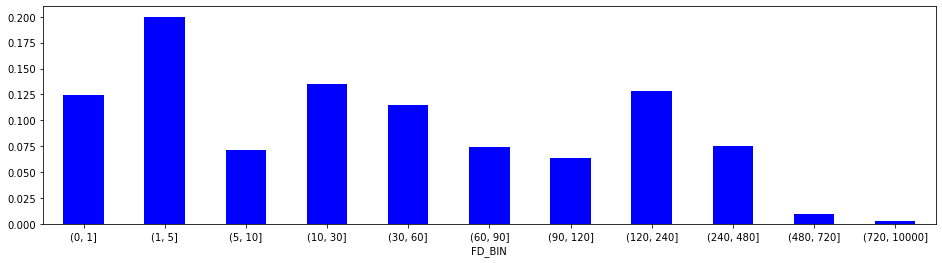

In [10]:
out = df.groupby('FD_BIN')['TVM'].count()/df.shape[0]
ax = out.plot.bar(rot=0, color='b', figsize=(16,4))
plt.show()

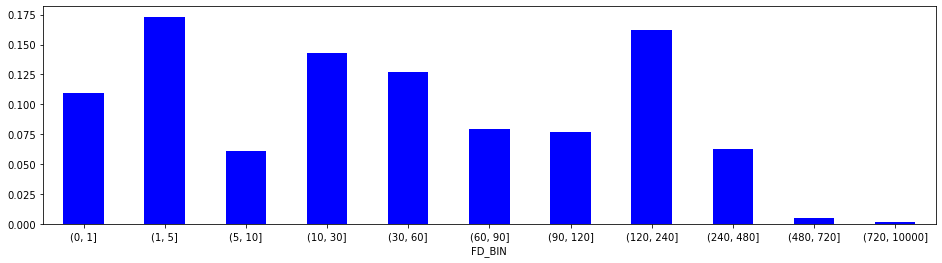

In [40]:
out = df[df['UTM_IND'] == 1].groupby('FD_BIN')['TVM'].count()/df[df['UTM_IND'] == 1]['UTM_IND'].count()
ax = out.plot.bar(rot=0, color='b', figsize=(16,4))
plt.show()


In [41]:
pd.concat([pd.DataFrame(df[df['UTM_IND'] == 0].groupby('FD_BIN')['TVM'].count()/df[df['UTM_IND'] == 0]['UTM_IND'].count()).
          rename(columns = {'TVM': 'NonCFeed'}), pd.DataFrame(df[df['UTM_IND'] == 1].groupby('FD_BIN')['TVM'].count()/
                                                           df[df['UTM_IND'] == 1]['UTM_IND'].count()).
          rename(columns = {'TVM': 'CFeed'}), pd.DataFrame(df.groupby('FD_BIN')['TVM'].count()/df.shape[0]).
           rename(columns = {'TVM': 'TTL'})], axis = 1)


,NonCFeed,CFeed,TTL
FD_BIN,,,
"(0, 1]",0.13,0.11,0.12
"(1, 5]",0.22,0.17,0.20
"(5, 10]",0.08,0.06,0.07
"(10, 30]",0.13,0.14,0.14
"(30, 60]",0.11,0.13,0.11
"(60, 90]",0.07,0.08,0.07
"(90, 120]",0.06,0.08,0.06
"(120, 240]",0.11,0.16,0.13
"(240, 480]",0.08,0.06,0.08


In [38]:
df[df['UTM_IND'] == 1].groupby('FD_BIN')['TVM'].count()/df[df['UTM_IND'] == 1]['UTM_IND'].count()

FD_BIN
(0, 1]         0.11
(1, 5]         0.17
(5, 10]        0.06
(10, 30]       0.14
(30, 60]       0.13
(60, 90]       0.08
(90, 120]      0.08
(120, 240]     0.16
(240, 480]     0.06
(480, 720]     0.00
(720, 10000]   0.00
Name: TVM, dtype: float64